# Traveling salesman

This problem involves minimizing the sum of edge weights $W_{u\nu}$ between nodes $u$ and $\nu$ in a graph $G=(V,E)$ under the constraint that the sum over edges is restricted to a set of $E$ which are connected by vertices $V$, where each vertex is used exactly once in joining the edges.

Let $\nu$ represent the vertex and $i$ represent its order in a prospective cycle, the $x_{\nu,i}$ are binary variables representing the possible states of the system: one if the vertex $\nu$ is the $i$-th order in the cycle and zero otherwise. The Hamiltonian has four terms:
1. The $x_{\nu,i}$ one-hot encode the order in which vertices appear. A penalisation term appears if not exactly one vertex is active at each stage. I.e. the salesman cannot be at multiple vertices at the same time: `simultaneous_constraint`.
1. A penalisation term appears if the salesman doesn't arrive at a vertex exactly once: `visits_constraint`.
1. A penalisation term if an edge is included which doesn't appear in the graph $G$.
1. The distance term taken from the sum over all $W_{u\nu}$ for $u$ and $\nu$ vertices appearing in the cycle.

$$
\begin{align}
H = & A\sum_{\nu=1}^{n}\left(1 - \sum_{j=1}^{N}x_{\nu,j}\right)^2
    + A\sum_{j=1}^{n}\left(1 - \sum_{\nu=1}^{N}x_{\nu,j}\right)^2 \\
    & + A\sum_{u\nu\notin E}\sum_{j=1}^{N}x_{u,j}x_{\nu,j+1}
    + B\sum_{u\nu\in E}W_{u\nu}\sum_{j=1}^{N}x_{u,j}x_{\nu,j+1}
\end{align}
$$

The parameter $B$ must be small enough that it is never favourable to violate the other constraints: i.e. $0<B\max(W_{u\nu})<A$.

In the traveling salesman problem the set of edges includes all possible combinations between the vertices. Therefore, there will be no penalisation from connections not appearing in the edges of the graph. Therefore, the Hamiltonian is reduced to:

$$
\begin{align}
H = & A\sum_{\nu=1}^{N}\left(1 - \sum_{j=1}^{N}x_{\nu,j}\right)^2
    + A\sum_{j=1}^{N}\left(1 - \sum_{\nu=1}^{N}x_{\nu,j}\right)^2 \\
    & + \sum_{u=1}^{N}\sum_{\nu=1,\nu\neq u}^{N}W_{u\nu}\sum_{j=1}^{N}x_{u,j}x_{\nu,j+1}
\end{align}
$$

The parameter $B$ has been absorbed into $A$, and hence $A>\max(W_{u\nu})$. The weight $W_{u\nu}$ is simply the euclidean distance between two points:

$$W_{u\nu} = \sqrt{(u_x - \nu_x)^2 + (u_y - \nu_y)^2}$$

In [1]:
pip install numpy matplotlib scipy pyqubo

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

from pyqubo import Array, Placeholder, Sum, Constraint, solve_qubo

from utils import plot_graph

# Graph

Define the graph and the vertices. The number of vertices is equal to the number of binary variables we need to initialise in the array.

# Hamiltonian

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99c4b8ab20>)

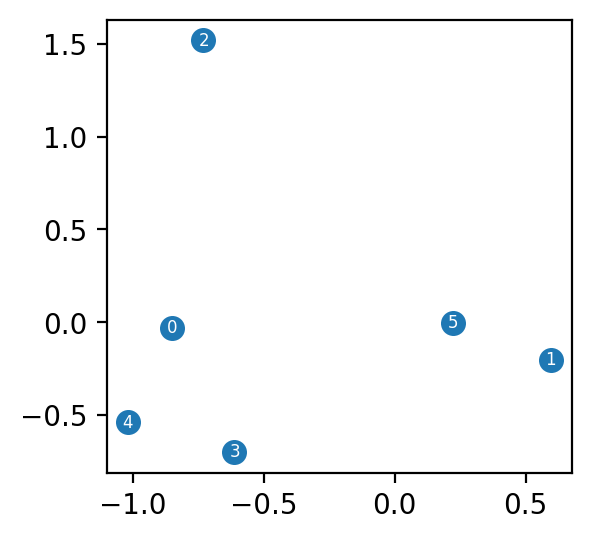

In [2]:
#graph = np.random.randn(6, 2)
graph = np.array([
    [-0.8494, -0.0292],
    [ 0.5966, -0.2025],
    [-0.7303,  1.5206],
    [-0.6110, -0.6992],
    [-1.0172, -0.5384],
    [ 0.2233, -0.0027],
])
plot_graph(graph)

The weights are precalculated from the euclidean distance between each point (using the scipy function `cdist`)

In [3]:
weights = cdist(graph, graph)
weights.shape

(6, 6)

In [4]:
x = Array.create('x', shape=weights.shape, vartype='BINARY')

Placeholder for the parameters of the Hamiltonian used to exercise the constraints.

In [5]:
A = Placeholder('A')

In [6]:
# (sum_i ((sum_j x[i,j])-1)**2)
simultaneous_constraint = 0.
for i in range(graph.shape[0]):
    simultaneous_constraint += Constraint(
        (Sum(0, graph.shape[0], lambda j: x[i,j])-1)**2,
        label=f"vertex{i}",
    )

# (sum_j ((sum_i x[i,j])-1)**2)
visits_constraint = 0.
for j in range(graph.shape[0]):
    visits_constraint += Constraint(
        (Sum(0, graph.shape[0], lambda i: x[i,j])-1)**2,
        label=f"edge{i}",
    )
    
# sum_i sum_j d[i,j] (sum_k (x[k,i] * x[k+1,j]))
distance = 0.
for i in range(graph.shape[0]):
    for j in range(graph.shape[0]):
        for k in range(graph.shape[0]-1):
            distance += weights[i,j]*x[k,i]*x[k+1,j]


We want to minimize the distance under certain constraints, hence we'll absort $B$ into $A$.

In [7]:
H = distance + A*(simultaneous_constraint + visits_constraint)
model = H.compile()

In [8]:
feed_dict = {"A": 4.}
qubo, offset = model.to_qubo(feed_dict=feed_dict)
sol = solve_qubo(qubo)
solution, broken, energy = model.decode_solution(
    sol, vartype='BINARY', feed_dict=feed_dict
)
print(f'Number of broken constraints: {len(broken)}')
print(f'Energy: {energy:.3f}')

Number of broken constraints: 0
Energy: 4.658


In [9]:
edges = np.array([
    list(x.values())
    for x in solution['x'].values()
], dtype='bool')
edges = np.where(edges)[1]
edges

array([0, 4, 3, 5, 1, 2])

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99c3923b20>)

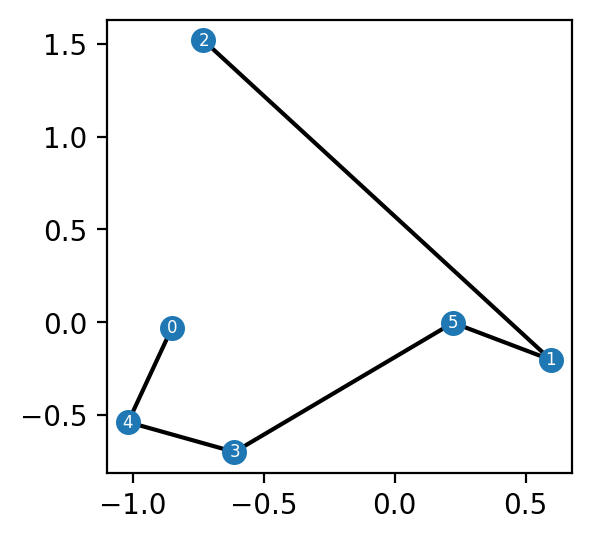

In [10]:
plot_graph(graph, edges=edges)